In [10]:
## 导入自定义cnn库
## layers中涉及卷积层，池化层，全连接层 前向反向传播
import numpy as np
from cnn.layers import fullyconnected_forward,fullyconnected_backward
from cnn.flat import flatten_forward,flatten_backward
from cnn.activations import relu_forward,relu_backward
from cnn.losses import cross_entropy_loss
from cnn.layers import Zeros_padding,Zeros_remove
from cnn.layers import convolution_forward,convolution_backward
from cnn.layers import maxpooling_forward,maxpooling_backward


In [11]:
# 初始化权重参数和偏置
weights = {} 
depth = 3  ##conv1的深度
fc_units=84  ##全连接层

##网络结构
##Input(1*28*28)=>convlution(3*5*5)=>relu()=>maxpooling(3*3)=>flatten()=>fullconnected(84)=>Output(10)
weights["K1"] = 1e-2 * np.random.randn(1, depth, 5, 5).astype(np.float64)
weights["b1"] = np.zeros(depth).astype(np.float64)
weights["W2"] = 1e-2 * np.random.randn(depth * 11 * 11, fc_units).astype(np.float64)
weights["b2"] = np.zeros(fc_units).astype(np.float64)
weights["W3"] = 1e-2 * np.random.randn(fc_units, 10).astype(np.float64)
weights["b3"] = np.zeros(10).astype(np.float64)

# 初始化神经元和梯度
nuerons={}
gradients={}

In [12]:
# 定义前向传播
#conv_
def forward(X):
    nuerons["conv1"]=convolution_forward(X.astype(np.float64),weights["K1"],weights["b1"])
    nuerons["conv1_relu"]=relu_forward(nuerons["conv1"])
    
    nuerons["maxp1"]=maxpooling_forward(nuerons["conv1_relu"].astype(np.float64),pooling=(3,3))
    nuerons["flatten"]=flatten_forward(nuerons["maxp1"])
    
    nuerons["fc2"]=fullyconnected_forward(nuerons["flatten"],weights["W2"],weights["b2"])
    nuerons["fc2_relu"]=relu_forward(nuerons["fc2"])
    nuerons["y"]=fullyconnected_forward(nuerons["fc2_relu"],weights["W3"],weights["b3"])

    return nuerons["y"]

# 定义反向传播
def backward(X,y_true):
    loss,dy=cross_entropy_loss(nuerons["y"],y_true)
    gradients["W3"],gradients["b3"],gradients["fc2_relu"]=fullyconnected_backward(dy,weights["W3"],nuerons["fc2_relu"])
    gradients["fc2"]=relu_backward(gradients["fc2_relu"],nuerons["fc2"])
    
    gradients["W2"],gradients["b2"],gradients["flatten"]=fullyconnected_backward(gradients["fc2"],weights["W2"],nuerons["flatten"])
    gradients["maxp1"]=flatten_backward(gradients["flatten"],nuerons["maxp1"])
       
    gradients["conv1_relu"]=maxpooling_backward(gradients["maxp1"].astype(np.float64),nuerons["conv1_relu"].astype(np.float64),pooling=(3,3))
    gradients["conv1"]=relu_backward(gradients["conv1_relu"],nuerons["conv1"])
    gradients["K1"],gradients["b1"],_=convolution_backward(gradients["conv1"],weights["K1"],X)
    return loss

In [13]:
# 获取精度
def get_accuracy(X,y_true):
    y_predict=forward(X)
    return np.mean(np.equal(np.argmax(y_predict,axis=-1),
                            np.argmax(y_true,axis=-1)))

In [14]:
##加载数据
import gzip
from six.moves import cPickle as pickle
import os
import platform
def load_mnist_datasets(path='./Data/mnist.pkl.gz'):
    if not os.path.exists(path):
        raise Exception('Cannot find %s' % path)
    with gzip.open(path, 'rb') as f:
        train_set, val_set, test_set = pickle.load(f, encoding='latin1')
        return train_set, val_set, test_set

In [15]:
from cnn.utils import to_categorical

#加载数据，分类训练集，验证集，测试集
train_set, val_set, test_set = load_mnist_datasets('./Data/mnist.pkl.gz')
train_x,val_x,test_x=np.reshape(train_set[0],(-1,1,28,28)),np.reshape(val_set[0],(-1,1,28,28)),np.reshape(test_set[0],(-1,1,28,28))
##https://keras.io/zh/utils/
train_y,val_y,test_y=to_categorical(train_set[1]),to_categorical(val_set[1]),to_categorical(test_set[1])

In [16]:
# 随机选择训练样本
train_num = train_x.shape[0]
def train_select(batch_size):
    index=np.random.choice(train_num,batch_size)
    return train_x[index],train_y[index]

x,y= train_select(16)
print("x.shape:{},y.shape:{}".format(x.shape,y.shape))

x.shape:(16, 1, 28, 28),y.shape:(16, 10)


In [17]:
from cnn.optimizers import SGD
##初始化变量
batch_size=4
steps = 2000  ##迭代
##初始化变量保存迭代步数step和loss值
steps_value = []
loss_value = []

# SVG更新梯度
sgd=SGD(weights,lr=0.01,decay=1e-6)

for s in range(steps):
    X,y=train_select(batch_size)
    
    forward(X)  # 前向过程
    loss=backward(X,y)  # 反向过程
    sgd.iterate(weights,gradients)  #更新迭代次数

    if s % 100 ==0:
        print("\n step:{:.2f}".format(s))
        print("\n loss:{}".format(loss))
        idx=np.random.choice(len(val_x),200)
        print(" test_accuracy:{}".format(get_accuracy(X,y)))
        print(" Verification_accuracy:{}".format(get_accuracy(val_x[idx],val_y[idx])))
        
        steps_value.append(s)
        loss_value.append(loss)
        
print("\n final result test_acc:{};  val_acc:{}".
      format(get_accuracy(test_x,test_y),get_accuracy(val_x,val_y)))


 step:0 ; loss:2.302754050072546
 train_acc:0.5;  val_acc:0.09

 step:100 ; loss:2.352906529252511
 train_acc:0.0;  val_acc:0.11

 step:200 ; loss:2.0813591792681123
 train_acc:0.5;  val_acc:0.145

 step:300 ; loss:1.1042564544185707
 train_acc:0.75;  val_acc:0.67

 step:400 ; loss:0.4971234200751079
 train_acc:1.0;  val_acc:0.725

 step:500 ; loss:1.0517269859010154
 train_acc:1.0;  val_acc:0.855

 step:600 ; loss:0.2849698746885541
 train_acc:1.0;  val_acc:0.875

 step:700 ; loss:0.188677337293153
 train_acc:1.0;  val_acc:0.895

 step:800 ; loss:0.4956972593254373
 train_acc:0.75;  val_acc:0.88

 step:900 ; loss:0.6403349924550067
 train_acc:0.75;  val_acc:0.845

 step:1000 ; loss:0.06334899403998301
 train_acc:1.0;  val_acc:0.84

 step:1100 ; loss:1.2059741134490898
 train_acc:0.75;  val_acc:0.905

 step:1200 ; loss:0.0444846927232782
 train_acc:1.0;  val_acc:0.905

 step:1300 ; loss:0.7207228014137018
 train_acc:0.75;  val_acc:0.91

 step:1400 ; loss:0.25696641175732715
 train_acc

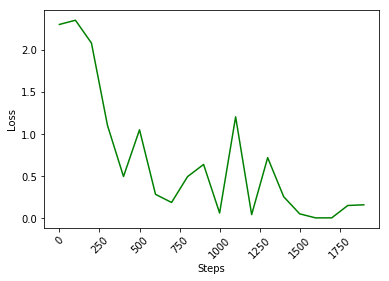

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

##绘制loss值和迭代次数的曲线
plt.plot(steps_value, loss_value,color='green')
plt.xticks(rotation=45)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

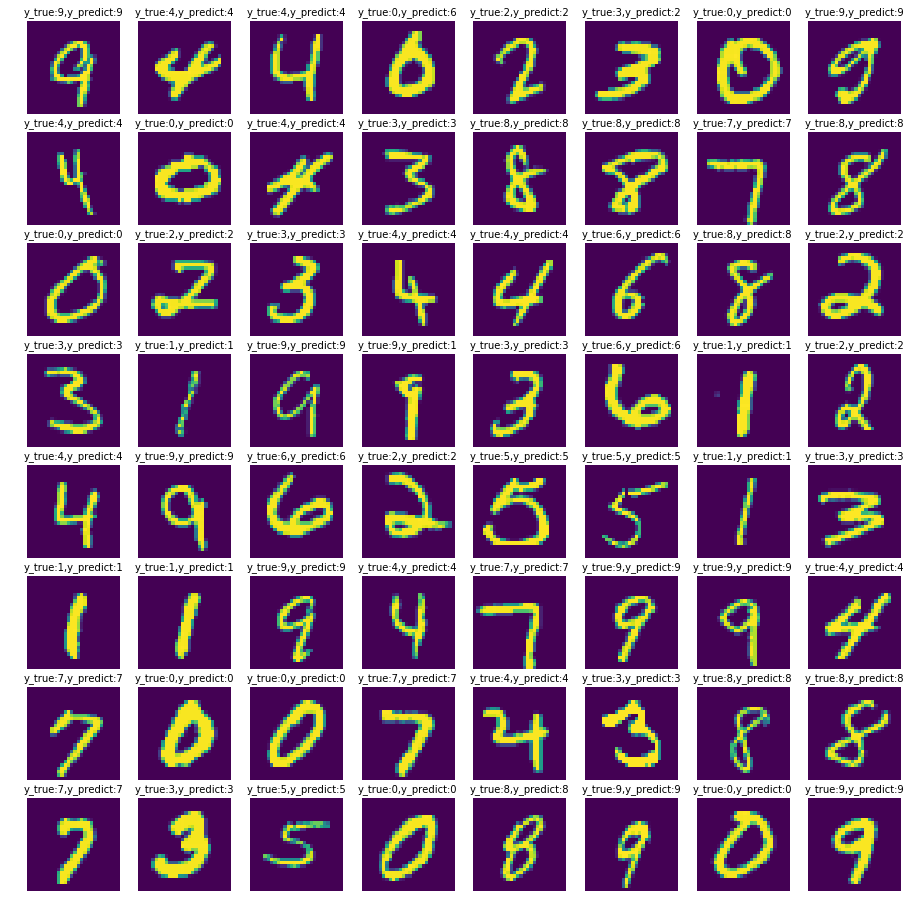

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

#绘制8*8个预测结果
fig, axs = plt.subplots(8, 8, figsize=(16, 16))
fig.subplots_adjust(hspace=.2, wspace=.001)
axs = axs.ravel()

idx=np.random.choice(test_x.shape[0],64)
x,y=test_x[idx],test_y[idx]
y_predict = forward(x)
for i in np.arange(64):
    axs[i].axis('off')
    axs[i].set_title("y_true:{},y_predict:{}".format(np.argmax(y[i]),np.argmax(y_predict[i])), fontsize=10)
    axs[i].imshow(np.reshape(x[i],(28,28)))